# 10K test
- take a slice of 12M_deriv dataset
- use the same prepro pipeline as for NIST stats
- evaluate and compare result with the one by geneval_extend

(=> if same, no bug should be there, if not same, the evaluation is corrupted~)

In [1]:
import numpy as np
from tqdm import tqdm
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools
from spectra_process_utils import process_neims_spec
from spectra_process_utils import preprocess_spectra, preprocess_spectrum
from tokenizers import Tokenizer
from geneval_utils import evaluate_range_opt2_prob

import sys
from dataset import SpectroDataset, SpectroDataCollator
sys.path.append('data')
sys.path.append('bart_spektro')
from modeling_bart_spektro import BartSpektoForConditionalGeneration
from configuration_bart_spektro import BartSpektroConfig

In [2]:
# hide rdkit warnings
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') 

In [5]:
# collect SMILES of k10 train+valid
k10_train_smiles = []
with open (f"./data/trial_set/10K_test.smi", "r") as f:
    lines = f.read().splitlines()
    k10_train_smiles += lines
k10_train_smiles = np.array(k10_train_smiles)

In [10]:
%%time
# canonicalize k10 train smiles
k10_train_smiles_cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in tqdm(k10_train_smiles)]


100%|██████████| 10000/10000 [00:02<00:00, 4148.94it/s][A

CPU times: user 2.41 s, sys: 9.55 ms, total: 2.42 s
Wall time: 2.42 s


In [4]:
# prepare k10 sdf and compose a command for k10 generation 
sdf_before = "/storage/brno2/home/ahajek/Spektro/MassGenie/tmp/tmp_for_k10.sdf"
sdf_after = "/storage/brno2/home/ahajek/Spektro/MassGenie/tmp/tmp_for_k10_enriched.sdf"

df_k10_plain = pd.DataFrame({"id": list(range(10000)),
                             "smiles": k10_train_smiles_cans})
PandasTools.AddMoleculeColumnToFrame(df_k10_plain, smilesCol='smiles', molCol='ROMol')
PandasTools.WriteSDF(df_k10_plain, sdf_before, idName="id", properties=list(df_k10_plain.columns))

print(f"now run in terminal:\n###############\nconda activate NEIMSpy2 && bash ~/Spektro/NEIMS/run_make_spectra_prediction.sh {sdf_before} {sdf_after} && conda deactivate\n###############\n")

NameError: name 'k10_train_smiles_cans' is not defined

In [5]:
df_k10_enriched = PandasTools.LoadSDF(sdf_after, idName="id", molColName="ROMol")

In [6]:
k10_spec = [process_neims_spec(row[1]["PREDICTED SPECTRUM"], 
                                 metadata={"smiles": row[1].smiles,
                                           "id": row[1].id}) 
                  for row in df_k10_enriched.iterrows()]

df_k10_enriched["k10_spec"] = k10_spec
df_k10_enriched.drop(columns=["PREDICTED SPECTRUM"], inplace=True)
df_k10_enriched.id = df_k10_enriched.id.astype(np.int32)

In [7]:
df_k10_enriched.k10_spec[0]

## Preprocess

In [8]:
tok = "./tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
tokenizer = Tokenizer.from_file(tok)

In [9]:
df_k10 = preprocess_spectra(df_k10_enriched.k10_spec, tokenizer, spectra_name="k10_spec")

  0%|          | 0/10000 [00:00<?, ?it/s]/auto/brno2/home/ahajek/Spektro/MassGenie/spectra_process_utils.py:92: RuntimeWarning: divide by zero encountered in log
  x = (np.log(intensities)/log_base).astype(int) + log_shift
100%|██████████| 10000/10000 [00:06<00:00, 1634.08it/s]

0 no smiles
0 smiles too long
0 spectra corrupted
0 spectra w/ too high mz
0 spectra w/ too many peaks
totally 0 issues
discarded 0/10000 spectra 


In [10]:
df_k10

,input_ids,position_ids,attention_mask,smiles,k10_spec
0,"[8, 9, 18, 33, 34, 36, 37, 38, 39, 40, 41, 42,...","[0, 0, 0, 3, 3, 1, 5, 5, 7, 5, 6, 6, 6, 5, 6, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",O=c1cc(CN(Cc2ccco2)Cc2ccco2)nc2sccn12,<matchms.Spectrum.Spectrum object at 0x14bf866...
1,"[34, 38, 39, 40, 41, 42, 50, 51, 52, 53, 55, 5...","[0, 4, 6, 4, 6, 3, 6, 5, 6, 6, 5, 0, 3, 1, 6, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",O=C(Nc1ccc(OC(=O)C2CC2)cc1)c1ccccc1Br,<matchms.Spectrum.Spectrum object at 0x14bf866...
2,"[15, 26, 27, 28, 29, 37, 38, 39, 40, 41, 42, 4...","[1, 0, 0, 2, 4, 1, 4, 6, 4, 4, 5, 6, 5, 7, 4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",COc1cc(C(=O)O[Si](C)(C)C)n(-c2ccc(F)cc2)n1,<matchms.Spectrum.Spectrum object at 0x14bf866...
3,"[33, 37, 38, 39, 40, 41, 42, 43, 44, 45, 50, 5...","[4, 2, 5, 8, 7, 8, 9, 9, 8, 6, 5, 7, 7, 7, 8, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",O=C(NCc1cc(COc2ccccc2F)on1)N1CCCCO1,<matchms.Spectrum.Spectrum object at 0x14bf866...
4,"[27, 28, 29, 33, 34, 38, 39, 40, 41, 42, 44, 4...","[4, 1, 3, 5, 0, 5, 9, 7, 9, 9, 8, 9, 4, 4, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",COCCN1CCC(CN(Cc2ccncc2)Cc2cccc(F)c2)CC1,<matchms.Spectrum.Spectrum object at 0x14bf866...
...,...,...,...,...,...
9995,"[27, 30, 33, 38, 39, 40, 41, 42, 43, 44, 45, 5...","[4, 5, 2, 4, 8, 7, 9, 9, 8, 7, 3, 6, 7, 6, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Cc1nn(CC(C)C)c(C)c1CC(=O)N1CCCN(C)c2ccccc21,<matchms.Spectrum.Spectrum object at 0x14bf859...
9996,"[14, 25, 26, 27, 28, 32, 33, 34, 35, 36, 37, 3...","[2, 3, 4, 3, 3, 0, 0, 1, 5, 6, 7, 7, 7, 7, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Clc1nccn2c(Br)ccc12,<matchms.Spectrum.Spectrum object at 0x14bf859...
9997,"[15, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[1, 1, 1, 3, 5, 8, 7, 9, 8, 9, 8, 6, 2, 6, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCC12COC(=O)N1CCN(C(=O)c1cccc(NC(=O)C(C)C)c1)C2,<matchms.Spectrum.Spectrum object at 0x14bf859...
9998,"[33, 38, 39, 40, 41, 42, 43, 44, 45, 49, 50, 5...","[0, 3, 6, 4, 5, 5, 6, 4, 2, 2, 6, 7, 7, 6, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",COc1ccc(NC(=O)Cn2c(=O)n(C)c(=O)c3ccccc32)c(OC)c1,<matchms.Spectrum.Spectrum object at 0x14bf859...


In [11]:
k10_data = SpectroDataset(df_k10, original=False, eval_mode=True)

In [15]:
# init model
global model_path
# model_path = f'./models/bart_2022-10-14-16_15_31_ft_12M_derivatized/checkpoint-58536/'
model_path = f'./models/bart_2022-10-14-16_15_31_ft_12M_derivatized/checkpoint-58536/'
model_name = ''.join(model_path.split('/')[-3])
model = BartSpektoForConditionalGeneration.from_pretrained(model_path)

# put model into eval mode and on device
model.eval()
device = 'cuda' # 'cpu' alternatively
model.to(device)

# change some configs
model.config.eos_token_id = 0
model.config.bos_token_id = 3
model.config.pad_token_id = 2
model.config.decoder_start_token_id = 3
model.config.forced_eos_token_id = 0
model.config.max_length = 200
model.config.min_length = 0

  0%|          | 0/10000 [00:00<?, ?it/s]/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 10000/10000 [53:42<00:00,  3.10it/s] 
/auto/brno2/home/ahajek/Spektro/MassGenie/geneval_utils.py:357: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(np.sum((is_sorted_by_gt_indexes - gt_sorted_by_gt_indexes)**2)/len(is_sorted_by_gt_indexes))


###### RESULTS ######
model: bart_2022-10-14-16_15_31_ft_12M_derivatized
additional info: _10ktest
data range: (0, 9999)
generated for each example: 10 samples
data type: 10k_data
mean RMSE of prob_simil ranking compared to GT: nan
recall@1: 0.3865
recall@3: 0.6797
average smiles simil from all unique samples: 0.5798758707387955
average simles simil from the 3 best samples: 0.6962618249312159
average smiles simil from the 1 best sample: 0.7443831411513022
mean num of unique vals: 6.0215



Text(0.5, 1.0, 'model: bart_2022-10-14-16_15_31_ft_12M_derivatized\nadditional info: _10ktest\ndata range: (0, 9999)\ngenerated for each example: 10 samples\ndata type: 10k_data\nmean RMSE of prob_simil ranking compared to GT: nan\nrecall@1: 0.3865\nrecall@3: 0.6797\naverage smiles simil from all unique samples: 0.5798758707387955\naverage simles simil from the 3 best samples: 0.6962618249312159\naverage smiles simil from the 1 best sample: 0.7443831411513022\nmean num of unique vals: 6.0215\n')

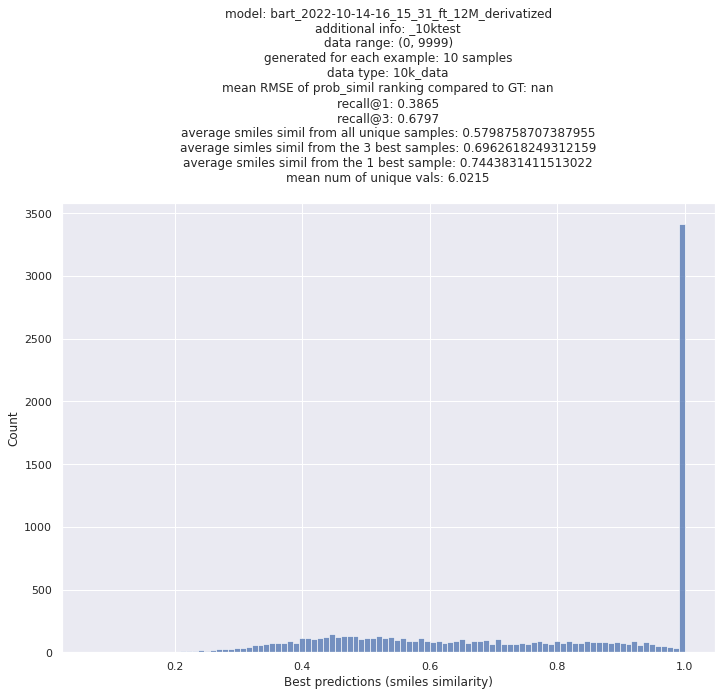

In [16]:
# evaluate NEIMS
RANGE = range(0,10000)
additional_info = "_10ktest"
evaluate_range_opt2_prob(model, 
                         model_name, 
                         tokenizer, 
                         k10_data,
                         data_type="10k_data",
                         data_range=RANGE, 
                         additional_info=additional_info, 
                         gt_list=list(df_k10["smiles"])[min(RANGE):max(RANGE)+1], 
                         num_generated=10)